In [161]:
import sys
sys.path.append("..")

In [162]:
from data_tools.tools import *
from scipy.integrate import odeint

import seaborn as sns
from matplotlib import pyplot as plt

In [163]:

def g_paper(f, x):
        """
        df/dx = -lamb * np.exp(-lamb * x * k) * np.sin(lamb * x) - lamb * k * f

        solution: f(x) = np.exp(-lamb * x * k) * np.cos(lamb * x), f(0) = 1
        """
        lamb = 20
        k = 0.1
        return -lamb * np.exp(-lamb * x * k) * np.sin(lamb * x) - lamb * k * f

def g_exp(f, x):
    """
    df/dx = lamb * np.exp(f * k) 
    f(0.001) = np.log(0.001)

    solution: f(x) = np.log(x)
    """
    lamb = 1
    k = 1
    return np.exp(-f*k)*lamb

def g_exp_2(f, x):
    """
    df/dx = 2*f+4*cos(x)-8*sin(x), f(0) = 3

    solution: f(x) = 3*exp(2*x) + 4*sin(x)
    """
    return 2*f+4*np.cos(x)-8*np.sin(x)

mapping_of_g_functions = {
    "g_paper": g_paper,
    "g_exp": g_exp,
    "g_exp_2": g_exp_2
}

f_initial_mapping = {
    "g_paper": 1,
    "g_exp": np.log(0.001),
    "g_exp_2": 3
}

In [164]:
def get_relevant_info(df_row):
    df = df_row
    relevant_info = {}
    if df["method"] == "PQK":
        relevant_info["CI_num_layers"] = df["CI_num_layers"]
        relevant_info["CI_num_qubits"] = df["CI_num_qubits"]
        relevant_info["CI_encoding_circuit_label"] = df["CI_encoding_circuit_label"]
        relevant_info["gamma"] = df["gamma"]
    elif df["method"] == "FQK":
        relevant_info["CI_num_layers"] = df["CI_num_layers"]
        relevant_info["CI_num_qubits"] = df["CI_num_qubits"]
        relevant_info["CI_encoding_circuit_label"] = df["CI_encoding_circuit_label"]
    elif df["method"] == "classical_RBF":
        relevant_info["gamma"] = df["gamma"]
    return relevant_info

        

In [165]:

def solution_of_g_paper(x):
        """
        df/dx = -lamb * np.exp(-lamb * x * k) * np.sin(lamb * x) - lamb * k * f

        solution: f(x) = np.exp(-lamb * x * k) * np.cos(lamb * x), f(0) = 1
        """
        lamb = 20
        k = 0.1
        return np.exp(-lamb * x * k) * np.cos(lamb * x) 

def solution_of_g_exp(x):
    """
    df/dx = lamb * np.exp(f * k) 
    f(0.001) = np.log(0.001)

    solution: f(x) = np.log(x)
    """
    return np.log(x)

def solution_of_g_exp_2(x):
    """
    df/dx = 2*f+4*cos(x)-8*sin(x), f(0) = 3

    solution: f(x) = 3*exp(2*x) + 4*sin(x)
    """
    return 3*np.exp(2*x) + 4*np.sin(x)



In [166]:
x_span = np.linspace(0.0001, 1, 40)

analytical_solutions = {
    "g_paper": solution_of_g_paper(x_span),
    "g_exp": solution_of_g_exp(x_span),
    "g_exp_2": solution_of_g_exp_2(x_span)
}

numerical_solutions = {
    "g_paper": odeint(mapping_of_g_functions["g_paper"], f_initial_mapping["g_paper"], x_span[:]),
    "g_exp": odeint(mapping_of_g_functions["g_exp"], f_initial_mapping["g_exp"], x_span[:]),
    "g_exp_2": odeint(mapping_of_g_functions["g_exp_2"], f_initial_mapping["g_exp_2"], x_span[:]),
}


In [167]:
path_to_results = "../data/results/DE_2_6"
results_PQK = load_feather_folder_as_pd(path_to_results)
results_PQK["gamma"] = np.sqrt(0.5*1/results_PQK["sigma"])
results_PQK["analytical_solution"] = results_PQK["g_name"].apply(lambda x: analytical_solutions[x])
results_PQK["mse_with_analytical"] = results_PQK.apply(lambda x: np.mean((x["f_sol"] - x["analytical_solution"])**2), axis=1)
results_PQK = results_PQK.sort_values(by="mse_with_analytical")



0.2116084098815918


In [168]:
path_to_results = "../data/results/DE_2_5"
results_RBF = load_feather_folder_as_pd(path_to_results)
results_RBF["gamma"] = np.sqrt(0.5*1/results_RBF["sigma"])
results_RBF = results_RBF.sort_values(by="mse")
results_RBF["analytical_solution"] = results_RBF["g_name"].apply(lambda x: analytical_solutions[x])
results_RBF["mse_with_analytical"] = results_RBF.apply(lambda x: np.mean((x["f_sol"] - x["analytical_solution"])**2), axis=1)

0.011295557022094727


In [169]:
path_to_results = "../data/results/DE_2_4"
results_FQK = load_feather_folder_as_pd(path_to_results)
results_FQK = results_FQK.sort_values(by="mse")
results_FQK["analytical_solution"] = results_FQK["g_name"].apply(lambda x: analytical_solutions[x])
results_FQK["mse_with_analytical"] = results_FQK.apply(lambda x: np.mean((x["f_sol"] - x["analytical_solution"])**2), axis=1)


0.0002346038818359375


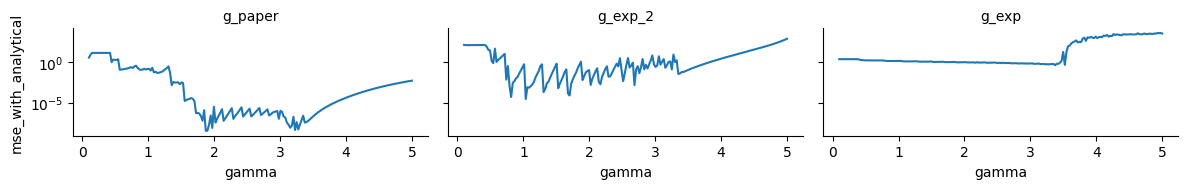

In [170]:
import seaborn as sns

g = sns.relplot(x="gamma", y="mse_with_analytical", 
                data=results_RBF.drop_duplicates(subset=["gamma", "g_name"]),
                kind="line", 
                col="g_name", 
                height=2,  # Adjust the height as needed
                aspect=2  
                )
g.set_titles("{col_name}")
g.set(yscale="log") 

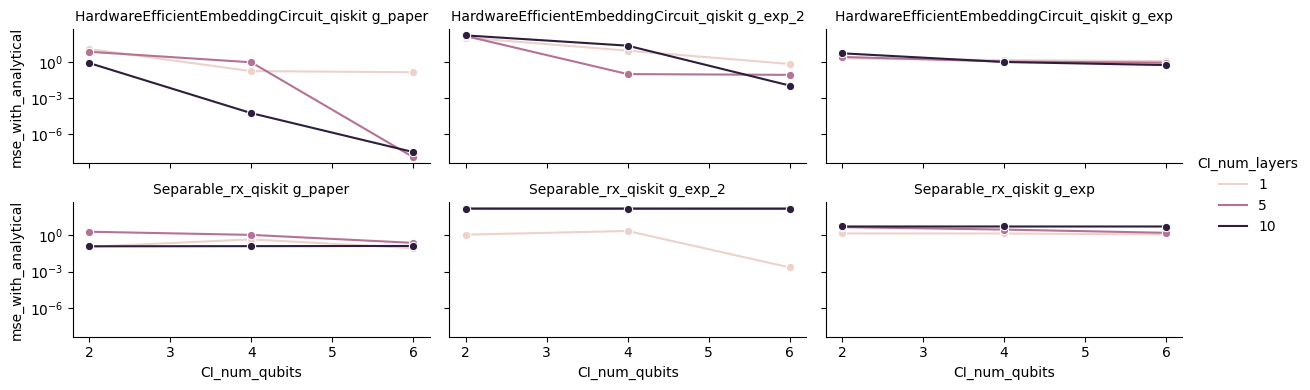

In [171]:
import seaborn as sns

g = sns.relplot(x="CI_num_qubits", y="mse_with_analytical", 
                data=results_FQK.drop_duplicates(subset=["CI_num_qubits", "CI_num_layers", "CI_encoding_circuit_label", "g_name"]),
                kind="line", 
                col="g_name", 
                row="CI_encoding_circuit_label", 
                hue="CI_num_layers",
                height=2,  # Adjust the height as needed
                aspect=2,  
                marker="o"
                )
g.set_titles("{row_name} {col_name}")
g.set(yscale="log") 

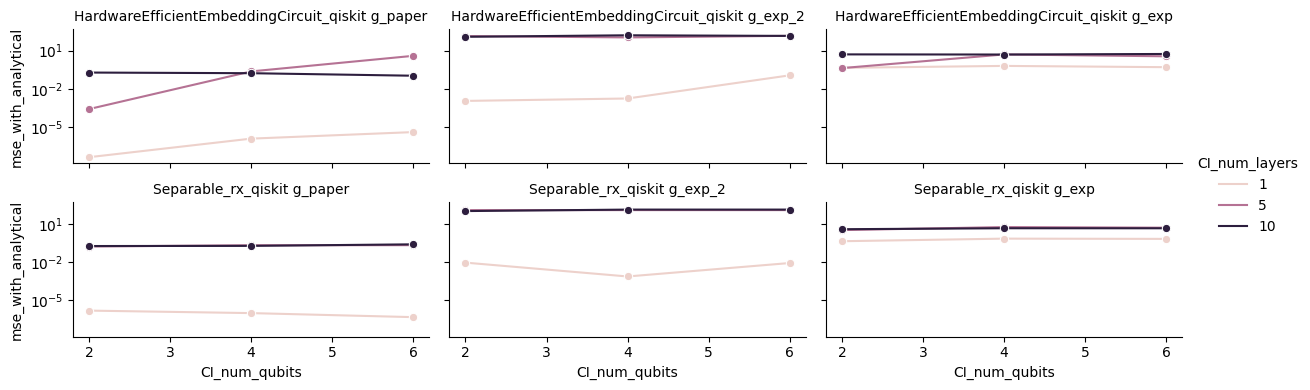

In [172]:
import seaborn as sns

g = sns.relplot(x="CI_num_qubits", y="mse_with_analytical", 
                data=results_PQK.drop_duplicates(subset=["CI_num_qubits", "CI_num_layers", "CI_encoding_circuit_label", "g_name"]),
                kind="line", 
                col="g_name", 
                row="CI_encoding_circuit_label", 
                hue="CI_num_layers",
                height=2,  # Adjust the height as needed
                aspect=2,  
                marker="o"
                )
g.set_titles("{row_name} {col_name}")
g.set(yscale="log") 

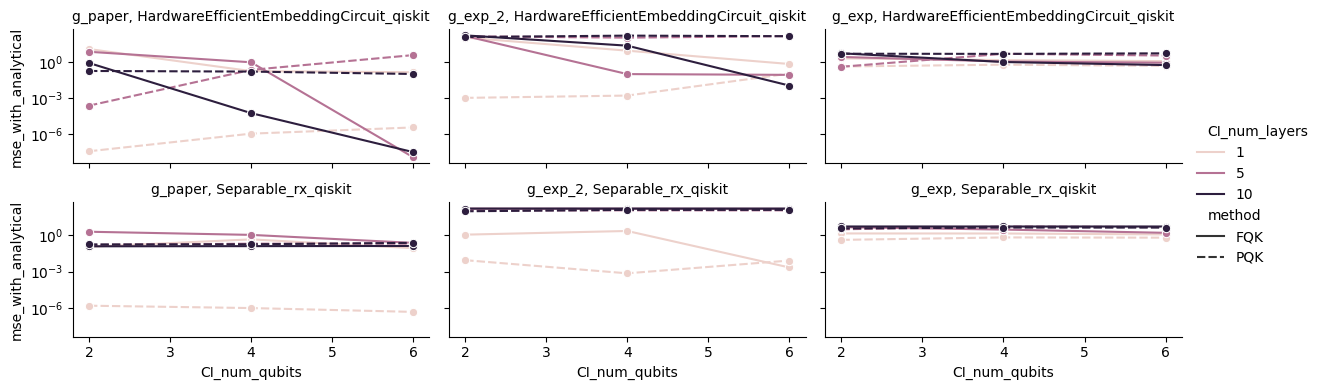

In [185]:
import seaborn as sns

results_FQK_plot = results_FQK.drop_duplicates(subset=["CI_num_qubits", "CI_num_layers", "CI_encoding_circuit_label", "g_name"])
results_PQK_plot = results_PQK.drop_duplicates(subset=["CI_num_qubits", "CI_num_layers", "CI_encoding_circuit_label", "g_name"])

#merge the results
results_QK_plot = pd.concat([results_FQK_plot, results_PQK_plot])

g = sns.relplot(x="CI_num_qubits", y="mse_with_analytical", 
                data=results_QK_plot,
                kind="line", 
                col="g_name", 
                row="CI_encoding_circuit_label", 
                hue="CI_num_layers",
                height=2,  # Adjust the height as needed
                aspect=2,  
                marker="o",
                style="method"
                )
g.set_titles("{col_name}, {row_name}")
g.set(yscale="log") 

<Axes: >

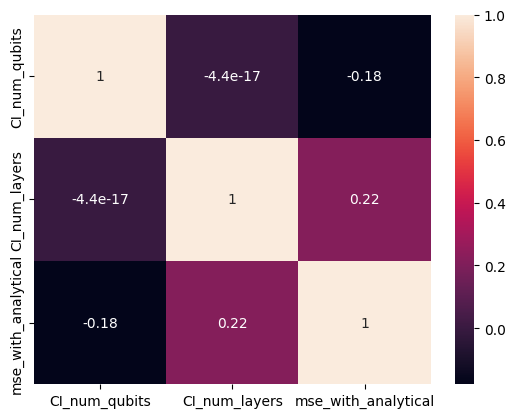

In [173]:
sns.heatmap(results_FQK[['CI_num_qubits', 'CI_num_layers', 'mse_with_analytical']].corr(method="pearson"), annot=True)

<Axes: >

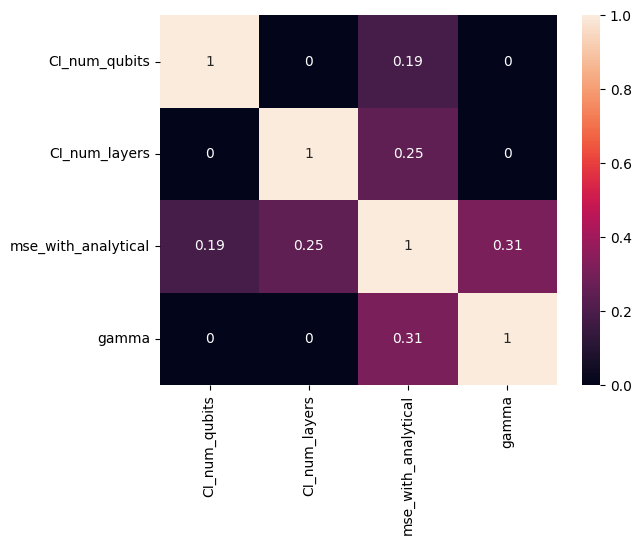

In [174]:
corr = results_PQK[['CI_num_qubits', 'CI_num_layers', 'mse_with_analytical', 'gamma']].corr(method="spearman") 
sns.heatmap(corr, annot=True)

{'CI_num_layers': 1, 'CI_num_qubits': 2, 'CI_encoding_circuit_label': 'HardwareEfficientEmbeddingCircuit_qiskit', 'gamma': 4.484210526315789}
{'CI_num_layers': 5, 'CI_num_qubits': 6, 'CI_encoding_circuit_label': 'HardwareEfficientEmbeddingCircuit_qiskit'}
{'gamma': 1.9221105527638191}


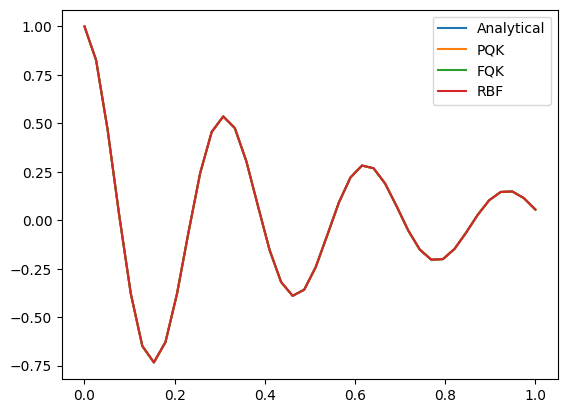

In [175]:
#result with lowest mse
g_name_to_plot = "g_paper"

x_span = np.linspace(0.0001, 1, 40)
plt.plot(x_span, analytical_solutions[g_name_to_plot], label="Analytical")
plt.plot(x_span, results_PQK[results_PQK["g_name"] == g_name_to_plot].iloc[0]["f_sol"], label="PQK")
plt.plot(x_span, results_FQK[results_FQK["g_name"] == g_name_to_plot].iloc[0]["f_sol"], label="FQK")
plt.plot(x_span, results_RBF[results_RBF["g_name"] == g_name_to_plot].iloc[0]["f_sol"], label="RBF")

plt.legend()

print(get_relevant_info(results_PQK[results_PQK["g_name"] == "g_paper"].iloc[0]))
print(get_relevant_info(results_FQK[results_FQK["g_name"] == "g_paper"].iloc[0]))
print(get_relevant_info(results_RBF[results_RBF["g_name"] == "g_paper"].iloc[0]))

{'CI_num_layers': 1, 'CI_num_qubits': 2, 'CI_encoding_circuit_label': 'HardwareEfficientEmbeddingCircuit_qiskit', 'gamma': 4.484210526315789}
{'CI_num_layers': 5, 'CI_num_qubits': 6, 'CI_encoding_circuit_label': 'HardwareEfficientEmbeddingCircuit_qiskit'}
{'gamma': 1.9221105527638191}


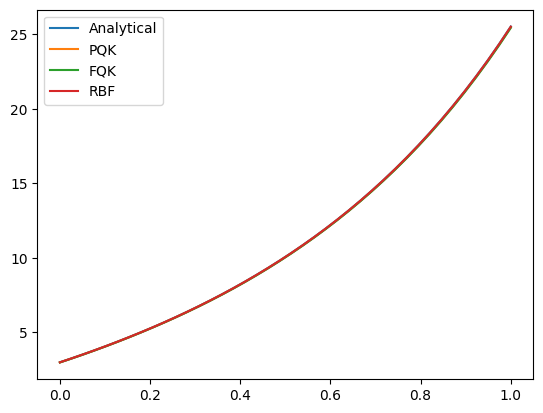

In [187]:
#result with lowest mse
g_name_to_plot = "g_exp_2"

x_span = np.linspace(0.0001, 1, 40)
plt.plot(x_span, analytical_solutions[g_name_to_plot], label="Analytical")
plt.plot(x_span, results_PQK[results_PQK["g_name"] == g_name_to_plot].iloc[0]["f_sol"], label="PQK")
plt.plot(x_span, results_FQK[results_FQK["g_name"] == g_name_to_plot].iloc[0]["f_sol"], label="FQK")
plt.plot(x_span, results_RBF[results_RBF["g_name"] == g_name_to_plot].iloc[0]["f_sol"], label="RBF")
plt.legend()

#print details of the best result
print(get_relevant_info(results_PQK[results_PQK["g_name"] == "g_paper"].iloc[0]))
print(get_relevant_info(results_FQK[results_FQK["g_name"] == "g_paper"].iloc[0]))
print(get_relevant_info(results_RBF[results_RBF["g_name"] == "g_paper"].iloc[0]))

{'CI_num_layers': 5, 'CI_num_qubits': 2, 'CI_encoding_circuit_label': 'HardwareEfficientEmbeddingCircuit_qiskit', 'gamma': 1.9052631578947368}
{'CI_num_layers': 10, 'CI_num_qubits': 6, 'CI_encoding_circuit_label': 'HardwareEfficientEmbeddingCircuit_qiskit'}
{'gamma': 3.2517587939698496}


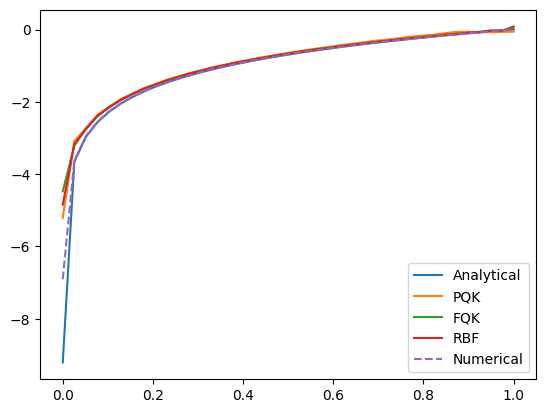

In [106]:
#result with lowest mse
g_name_to_plot = "g_exp"

x_span = np.linspace(0.0001, 1, 40)
plt.plot(x_span, analytical_solutions[g_name_to_plot], label="Analytical")
plt.plot(x_span, results_PQK[results_PQK["g_name"] == g_name_to_plot].iloc[0]["f_sol"], label="PQK")
plt.plot(x_span, results_FQK[results_FQK["g_name"] == g_name_to_plot].iloc[0]["f_sol"], label="FQK")
plt.plot(x_span, results_RBF[results_RBF["g_name"] == g_name_to_plot].iloc[0]["f_sol"], label="RBF")
plt.plot(x_span, numerical_solutions[g_name_to_plot], label="Numerical", linestyle="--")

plt.legend()

print(get_relevant_info(results_PQK[results_PQK["g_name"] == "g_exp"].iloc[0]))
print(get_relevant_info(results_FQK[results_FQK["g_name"] == "g_exp"].iloc[0]))
print(get_relevant_info(results_RBF[results_RBF["g_name"] == "g_exp"].iloc[0]))

In [152]:
from circuits.circuits import * 
from utils.rbf_kernel_tools import *

from solvers.MMR.PQK_solver import PQK_solver
from solvers.MMR.FQK_solver import FQK_solver
from solvers.MMR.kernel_solver import Solver


def get_K_from_row(row, method, executor_type):
    """Get the K matrix from a row in the results dataframe
    """
    x_span = np.linspace(0.0001, 1, 40)

    print(row["CI_encoding_circuit_label"])
    circuit_information = {"num_qubits": row["CI_num_qubits"],
                            "num_layers": row["CI_num_layers"],
                            "encoding_circuit": circuits_dictionary_qiskit[row["CI_encoding_circuit_label"]]
                            }
    print(circuit_information)
    if method == "PQK":
        O_Solver = PQK_solver(circuit_information, executor_type, envelope={"function": rbf_kernel_manual, 
                                            "derivative_function": analytical_derivative_rbf_kernel, 
                                            "sigma": row["sigma"]})
    elif method == "FQK":
        O_Solver = FQK_solver(circuit_information, executor_type)
    elif method == "classical_RBF":
        O_Solver = Solver(circuit_information)

    
    
    return O_Solver.get_Kernel(x_span)

In [159]:
best_K_PQK = get_K_from_row(results_PQK[results_PQK["g_name"] == g_name_to_plot].iloc[0], "PQK", Executor("statevector_simulator"))
worst_K_PQK = get_K_from_row(results_PQK[results_PQK["g_name"] == g_name_to_plot].iloc[-1], "PQK", Executor("statevector_simulator"))

HardwareEfficientEmbeddingCircuit_qiskit
{'num_qubits': 2, 'num_layers': 5, 'encoding_circuit': <function HardwareEfficientEmbeddingCircuit_qiskit at 0x00000245D88D6680>}
HardwareEfficientEmbeddingCircuit_qiskit
{'num_qubits': 4, 'num_layers': 5, 'encoding_circuit': <function HardwareEfficientEmbeddingCircuit_qiskit at 0x00000245D88D6680>}


In [155]:
def eigendecomposition(K):
    """Returns ordered eigenvalues and normalized eigenvectors of a kernel matrix."""
    eigenvalue_spectrum, eigenvectors = np.linalg.eigh(1/K.shape[0] * K)
    inds_sort = np.argsort(eigenvalue_spectrum)
    inds_sort = inds_sort[::-1]
    eigenvalue_spectrum = eigenvalue_spectrum[inds_sort]
    eigenvectors = eigenvectors[:,inds_sort]
    return eigenvalue_spectrum, eigenvectors

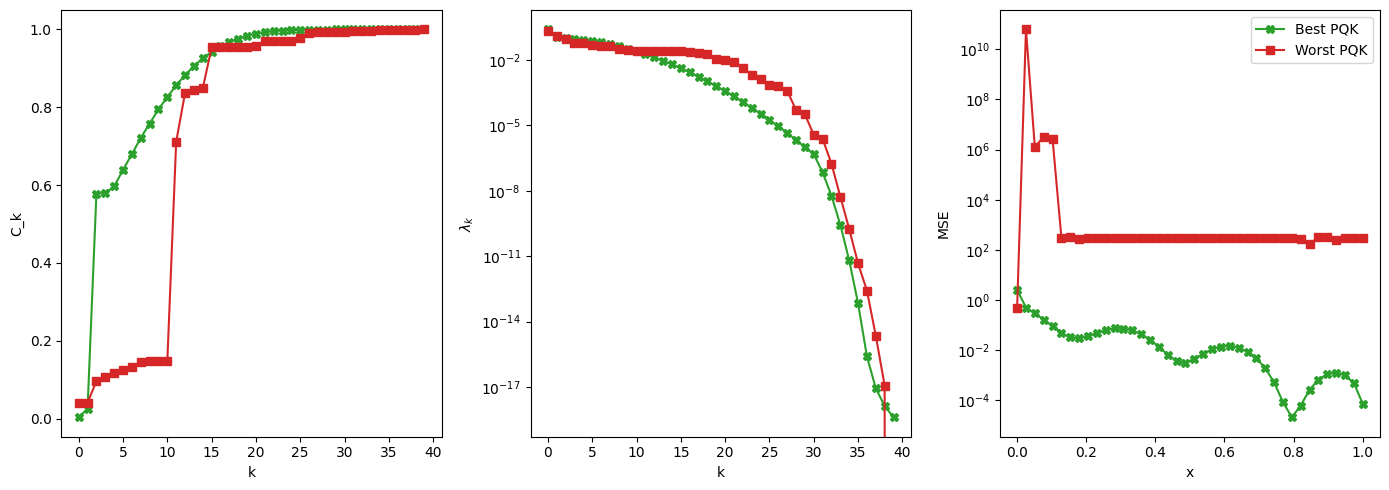

In [157]:
kernel_tensor = [best_K_PQK, worst_K_PQK]
solution_list = [results_PQK.iloc[0]["f_sol"], results_PQK.iloc[-1]["f_sol"]]

marker = ["X-", "s-", "o-"]

labels = ["Best PQK", "Worst PQK"]

#two column plot axes
fig, axs = plt.subplots(1, 3, figsize=(14, 5))
for idx_kernel, kernels in enumerate(kernel_tensor):
    K_f = kernels
    eigenvalue_spectrum, eigenvectors = eigendecomposition(K_f)    

    y_train_for_analytical = analytical_solutions[g_name_to_plot]
    if len(y_train_for_analytical.shape) == 1:
        y_train_for_analytical = y_train_for_analytical.reshape(-1, 1)

    #y_train is a column vector
    power = np.sum((eigenvectors.T @ y_train_for_analytical)**2, axis = 1)
    cumul = np.cumsum(power) / np.sum(power)


    axs[0].plot(cumul,marker[idx_kernel], label = f"{labels[idx_kernel]}", color = f"C{idx_kernel+2}")
    axs[0].set_ylabel("C_k")
    axs[0].set_xlabel("k")
    

    axs[1].plot(eigenvalue_spectrum, marker[idx_kernel], label = f"{labels[idx_kernel]}", color = f"C{idx_kernel+2}")
    axs[1].set_ylabel("$\lambda_k$")
    axs[1].set_xlabel("k")
    axs[1].set_yscale("log")    


    #mean squared error as a function of x

    mse = (solution_list[idx_kernel] - analytical_solutions[g_name_to_plot])**2/ len(x_span)

    axs[2].plot(x_span, mse, marker[idx_kernel], label = f"{labels[idx_kernel]}", color = f"C{idx_kernel+2}")
    axs[2].set_ylabel("MSE")
    axs[2].set_yscale("log")
    axs[2].set_xlabel("x")


plt.tight_layout()
plt.legend()
